In [1]:
import os
import sys
import numpy as np
from scipy import sparse
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.mplot3d import Axes3D, axes3d
from scipy.cluster import hierarchy
import seaborn as sns
import spacy
import nltk
from konlpy.tag import Okt
import graphviz

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [50]:
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer

In [ ]:
# OneHotEncoder
# (parameter) sparse : 희소 행렬 반환(default: True)
# (etc) pd.get_dummies(data, columns=[])
# (method) get_feature_names_out : 원본 범주형 변수 이름 반환(특성 이름 반환)

# ColumnTransformer : 튜플 들의 리스트로 구성 → Scaling 및 인코딩 전처리 동시 수행
# → 각 튜플은 '이름', '모듈', '모듈에 적용할 리스트'로 구성
# make_column_transformer 활용 가능

# KBinsDiscretizer
# (parameter) n_bins : 구간의 개수(default: 5)
# (parameter) strategy : 구간 내 너비의 전략 결정(uniform, kmeans... default: quantile)
# (parameter) encode : 결과 데이터 인코딩(onehot, onehot-dense, ordinal... default: onehot)
# (attribution) bin_edges, n_bins_

# PolynomialFeatures
# (parameter) degree : 다항식의 차원 수 지정(2, (1, 3)... default: 2)
# (parameter) include_bias : True일 경우 절편에 해당하는 1인 특성 추가(default: True)
# (parameter) interaction_only : 상호간의 곱 들만 포함하며, 동일 값 제곱 등은 제외(default: False)
# (method) get_feature_names_out

# SelectKBest, SelectPercentile : f_classif, f_regression도 import해와야
# (parameter) score_func : 분류일 경우 f_classif, 회귀일 경우 f_regression
# (parameter) k 또는 percentile : 특성 자동선택 개수(퍼센트) 지정(default: 10, 10)
# (method) get_support() : 선택된 특성을 불리언 값으로 표시

# SelectFromModel : 추정기를 통한 특성 선택 → 첫 번째 파라미터로 추정기
# (parameter) threshold : 해당 임계치보다 큰 모든 특성을 선택(median, 1.2*mean... default: mean)

# RFE(재귀적 특성 제거) : 마찬가지로 추정기를 통한 특성 선택 → 첫 번째 파라미터로 추정기
# (parameter) n_features_to_select : 최종적으로 선택할 특성의 개수

In [4]:
data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'adult.data'), header=None, index_col=False,
                  names = ['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
data = data.loc[:, ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income']]

In [5]:
data.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


In [6]:
for col in data.columns:
    print(f'{col}: {data[col].unique()}')

age: [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
workclass: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
education: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
gender: [' Male' ' Female']
hours-per-week: [40 13 16 45 50 80 30 35 60 20 52 44 15 25 38 43 55 48 58 32 70  2 22 56
 41 28 36 24 46 42 12 65  1 10 34 75 98 33 54  8  6 64 19 18 72  5  9 47
 37 21 26 14  4 59  7 99 53 39 62 57 78 90 66 11 49 84  3 17 68 27 85 31
 51 77 63 23 87 88 73 89 97 94 29 96 67 82 86 91 81 76 92 61 74 95]
occupation: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service'

In [7]:
data_dummies = pd.get_dummies(data)
data_dummies.head()

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,50,13,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,38,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,53,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,40,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [8]:
X = data_dummies.iloc[:, :-2].values
y = data_dummies.iloc[:, -2].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [10]:
logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8137592137592138, 0.8088686893502027)

In [11]:
demo_df = pd.DataFrame({'숫자':[0, 1, 2, 1], '범주':['양말', '여우', '양말', '상자']})
pd.get_dummies(demo_df, columns=['숫자', '범주'])

,숫자_0,숫자_1,숫자_2,범주_상자,범주_양말,범주_여우
0,1,0,0,0,1,0
1,0,1,0,0,0,1
2,0,0,1,0,1,0
3,0,1,0,1,0,0


In [12]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(demo_df) == pd.get_dummies(demo_df, columns=['숫자', '범주']).values

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [13]:
ohe.get_feature_names_out()

array(['숫자_0', '숫자_1', '숫자_2', '범주_상자', '범주_양말', '범주_여우'], dtype=object)

In [14]:
data_features = data.iloc[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(data_features, data['income'], random_state=0)
ct = make_column_transformer((StandardScaler(), ['age', 'hours-per-week'])
                             , (OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation']))
X_train_trans = ct.fit_transform(X_train)
X_test_trans = ct.transform(X_test)
logreg = LogisticRegression(max_iter=1000).fit(X_train_trans, y_train)
logreg.score(X_train_trans, y_train), logreg.score(X_test_trans, y_test)

(0.8136773136773137, 0.808991524382754)

In [15]:
X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

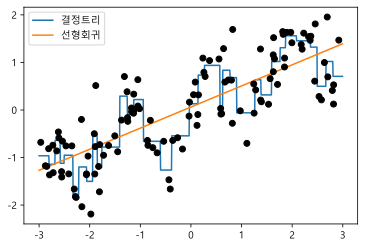

In [16]:
reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label='결정트리')
reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label='선형회귀')
plt.plot(X[:, 0], y, 'o', color='k')
plt.legend()
plt.show()

In [17]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform').fit(X)
kb.bin_edges_

array([array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
              -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
               2.92132162])                                                   ],
      dtype=object)

In [18]:
X_binned = kb.transform(X)
X_binned.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense').fit(X)
X_binned = kb.transform(X)
X_binned

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

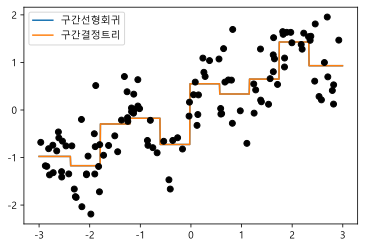

In [20]:
line_binned = kb.transform(line)
reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='구간선형회귀')
reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='구간결정트리')
plt.legend()
plt.plot(X[:, 0], y, 'o', color='k')

In [21]:
LinearRegression().fit(X, y).score(X, y), LinearRegression().fit(X_binned, y).score(X_binned, y)

(0.6263363499825908, 0.7237309728172019)

In [22]:
X_combined = np.hstack([X, X_binned])
line_combined = np.hstack([line, line_binned])

0.7277571512572492

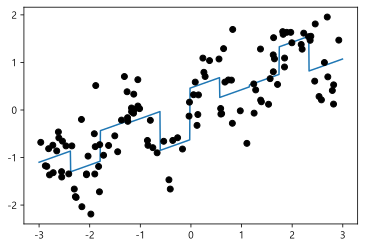

In [23]:
reg = LinearRegression().fit(X_combined, y)
plt.plot(line, reg.predict(line_combined))
plt.plot(X[:, 0], y, 'o', color='k')
reg.score(X_combined, y)

In [24]:
X_product = np.hstack([X_binned, X * X_binned])
line_product = np.hstack([line_binned, line * line_binned])

0.787287089329761

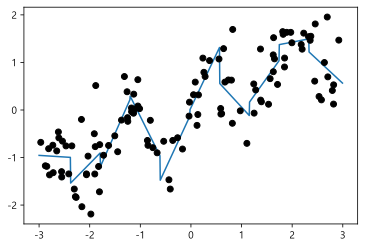

In [25]:
reg = LinearRegression().fit(X_product, y)
plt.plot(line, reg.predict(line_product))
plt.plot(X[:, 0], y, 'o', color='k')
reg.score(X_product, y)

In [26]:
kb.bin_edges_

array([array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
              -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
               2.92132162])                                                   ],
      dtype=object)

In [27]:
poly = PolynomialFeatures(degree=(1, 10), include_bias=False).fit(X)
X_poly = poly.transform(X)

In [28]:
poly.get_feature_names_out()

array(['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8',
       'x0^9', 'x0^10'], dtype=object)

0.7346894080529935

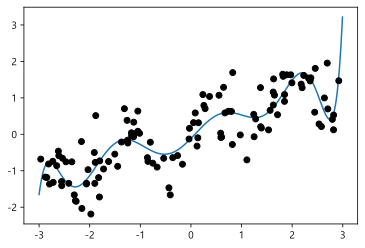

In [29]:
line_poly = poly.transform(line)
reg = LinearRegression().fit(X_poly, y)
plt.plot(line, reg.predict(line_poly))
plt.plot(X[:, 0], y, 'o', color='k')
reg.score(X_poly, y)

0.754165853312546
0.7792313050375593
0.7872376732593508


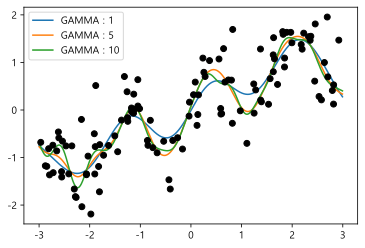

In [30]:
for gamma in [1, 5, 10]:
    svm = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svm.predict(line), label=f'GAMMA : {gamma}')
    print(svm.score(X, y))
plt.plot(X[:, 0], y, 'o', color='k')
plt.legend()

In [31]:
boston = load_boston()

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [32]:
X_train, X_test, y_train, y_test = train_test_split(boston['data'], boston['target'], random_state=0)

In [33]:
pipe = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2)).fit(X_train)
X_train_pipe = pipe.transform(X_train)
X_train_pipe.shape

(379, 105)

In [34]:
pipe.get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4',
       'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11',
       'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6',
       'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2',
       'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9',
       'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6',
       'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2',
       'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11',
       'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10',
       'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10',
       'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11',
       'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2',
       'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12',


In [35]:
pipe.named_steps['polynomialfeatures'].get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4',
       'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11',
       'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6',
       'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2',
       'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9',
       'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6',
       'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2',
       'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11',
       'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10',
       'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10',
       'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11',
       'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2',
       'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12',


In [36]:
pipe = make_pipeline(MinMaxScaler(), Ridge()).fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6214583227921036

In [37]:
pipe = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2), Ridge()).fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7534782020980574

In [38]:
pipe = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2), RandomForestRegressor(n_estimators=100, random_state=0)).fit(X_train, y_train)
pipe.score(X_test, y_test)

0.775366610027315

In [39]:
pipe = make_pipeline(MinMaxScaler(), RandomForestRegressor(n_estimators=100, random_state=0)).fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7951668527831127

In [40]:
pipe = make_pipeline(RandomForestRegressor(n_estimators=100, random_state=0)).fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7952684623500126

In [45]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)
X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)
X[:10, 0]

array([ 56,  81,  25,  20,  27,  18,  12,  21, 109,   7])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [48]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)
ridge = Ridge().fit(X_train_log, y_train)
ridge.score(X_test_log, y_test)

0.8749342372887816

(array([ 19.,  31.,  93.,  85., 127., 161., 127.,  62.,  32.,  13.]),
 array([0.        , 0.47957905, 0.95915811, 1.43873716, 1.91831622,
        2.39789527, 2.87747433, 3.35705338, 3.83663244, 4.31621149,
        4.79579055]),
 <BarContainer object of 10 artists>)

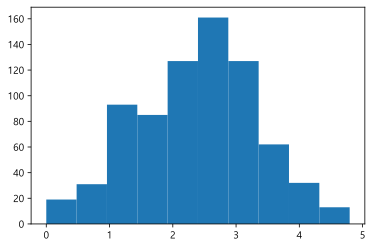

In [49]:
plt.hist(X_train_log[:, 0])

In [52]:
cancer = load_breast_cancer()

In [53]:
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer['data']), 50))
X_w_noise = np.hstack([cancer['data'], noise])
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer['target'], random_state=0, test_size=0.5)

In [56]:
select = SelectPercentile(score_func=f_classif, percentile=50).fit(X_train, y_train)
X_train_selected = select.transform(X_train)

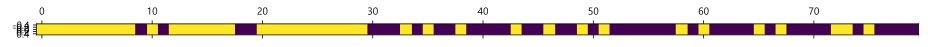

In [60]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))

In [64]:
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median').fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

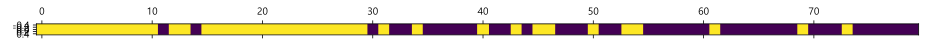

In [65]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))

In [66]:
X_test_l1 = select.transform(X_test)

In [68]:
logreg = LogisticRegression(max_iter=5000).fit(X_train_l1, y_train)
logreg.score(X_test_l1, y_test)

0.9473684210526315

In [71]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40).fit(X_train, y_train)
X_train_rfe = select.transform(X_train)

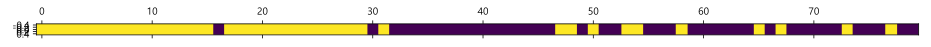

In [72]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))

In [74]:
X_test_rfe = select.transform(X_test)
logreg = LogisticRegression(max_iter=5000).fit(X_train_rfe, y_train)
logreg.score(X_test_rfe, y_test)

0.9403508771929825

In [75]:
select.score(X_test, y_test)

0.9508771929824561

In [76]:
citibike = mglearn.datasets.load_citibike()
citibike

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
                       ..
2015-08-31 09:00:00    16
2015-08-31 12:00:00     8
2015-08-31 15:00:00    17
2015-08-31 18:00:00    22
2015-08-31 21:00:00     7
Freq: 3H, Name: one, Length: 248, dtype: int64

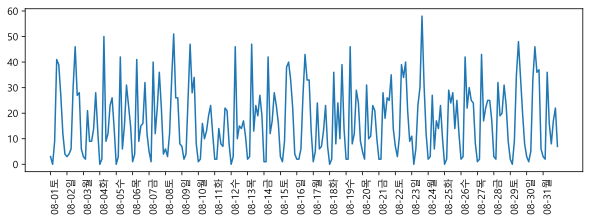

In [79]:
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
week = ['일', '월', '화', '수', '목', '금', '토']
xticks_name = [d + week[int(w)] for w, d in zip(xticks.strftime('%w'), xticks.strftime('%m-%d'))]
plt.figure(figsize=(10, 3))
plt.xticks(xticks, xticks_name, rotation=90, ha='left')
plt.plot(citibike)

In [85]:
citibike.index.astype('int64').values.reshape(-1, 1) // (10**9)

array([[1438387200],
       [1438398000],
       [1438408800],
       [1438419600],
       [1438430400],
       [1438441200],
       [1438452000],
       [1438462800],
       [1438473600],
       [1438484400],
       [1438495200],
       [1438506000],
       [1438516800],
       [1438527600],
       [1438538400],
       [1438549200],
       [1438560000],
       [1438570800],
       [1438581600],
       [1438592400],
       [1438603200],
       [1438614000],
       [1438624800],
       [1438635600],
       [1438646400],
       [1438657200],
       [1438668000],
       [1438678800],
       [1438689600],
       [1438700400],
       [1438711200],
       [1438722000],
       [1438732800],
       [1438743600],
       [1438754400],
       [1438765200],
       [1438776000],
       [1438786800],
       [1438797600],
       [1438808400],
       [1438819200],
       [1438830000],
       [1438840800],
       [1438851600],
       [1438862400],
       [1438873200],
       [1438884000],
       [14388

In [113]:
y = citibike.values
X = citibike.index.astype('int64').values.reshape(-1, 1) // 10**9
X_hour = citibike.index.hour.values.reshape(-1, 1)
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), citibike.index.hour.values.reshape(-1, 1)])

In [122]:
n_train = 184
def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print(f'{regressor.score(X_test, y_test):.2f}')
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    #xticks_name = [week[int(w)] + d for w, d in zip(xticks.strftime('%w'), xticks.strftime(' %m-%d'))]
    plt.figure(figsize=(10, 3))
    plt.xticks(xticks, xticks_name, rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='훈련')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='테스트')
    plt.plot(range(n_train), y_pred_train, '--', label='훈련예측')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label='테스트예측')
    plt.legend()
    plt.xlabel('날짜')
    plt.ylabel('대여횟수')

0.84


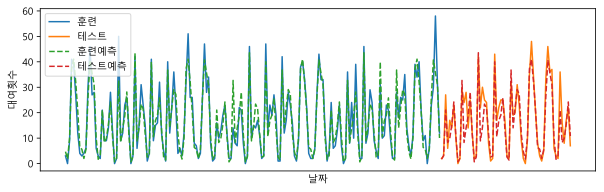

In [123]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_hour_week, y, regressor)

0.62


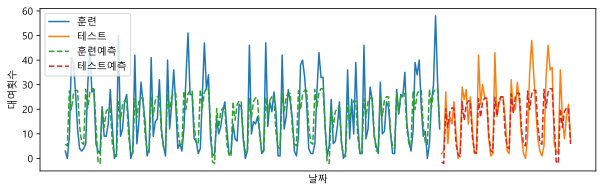

In [124]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())

0.85


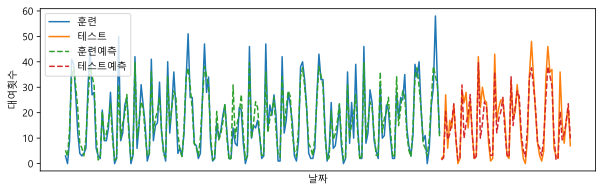

In [125]:
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
eval_on_features(X_hour_week_onehot_poly, y, Ridge())